# PKIS dataset curation

## Backgroud:
 Kinases play a crucial role in cellular signalling, making them important targets for drug development. Dysregulation of kinases is frequently implicated in diseases like cancer, inflammation, and neurodegenerative disorders. Therefore, targeting kinases with specific drugs has emerged as a crucial strategy in modern drug discovery. Kinase-related task includes inhibition prediction, selectivity prediction, or kinase-ligand binding affinity prediction. In the early release version of Polaris, benchmarks were established for kinases such as EGFR, KIT, and RET, along with their respective mutations, as well as for LOK and SLK.


## Description of readout 
- **Readouts**:
 - `EGFR`,`EGFR_(L858R_mutant)`
 - `KIT`, `KIT_(T6701_mutant)`, `KIT_(V560G_mutant)`
 - `RET`, `RET_(V804L_mutant)`, `RET_(Y791F_mutant)`
- **Bioassay readout**: Percentage of inhibition (%).
- **Optimization objective**: Higher potency (higher %inhibition).


## Data resource:
PKIS 1: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis.

**Reference**: https://pubmed.ncbi.nlm.nih.gov/26501955

<!-- ## Related benchmarks -->
<!-- TODO: to be added -->

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import datetime
import re
from polaris.curation._chemistry_curator import UNIQUE_ID

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

import os
import pathlib

os.chdir(pathlib.Path("__file__").absolute().parents[2])
import warnings

warnings.filterwarnings("ignore")

In [2]:
INDIR = "gs://polaris-public/data/raw"
OUTDIR = "gs://polaris-public/data/Kinases"

## Load the raw data
The dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955

In [3]:
data = pd.read_parquet(f"{INDIR}/pkis_matrix_1uM.parquet")
data.head(5)

Assay Description,Smiles,ABL1 (E255K mutant),ABL1 (H396P mutant),ABL1 (M351T mutant),ABL1 (Q252H mutant),ABL1 (T315I mutant),ABL1 (Y253F mutant),ABL1,AKT1,AKT2,...,TRKC,TSSK1,TSSK2,TTK,TXK,TYK2,TYRO3,YES,ZAP70,p70s6K1
0,C#Cc1cccc(Nc2ncnc3ccc(OCCCCNCCS(C)(=O)=O)cc23)c1,19.66,22.98,19.21,22.70,19.38,24.85,26.77,-3.06,-2.09,...,4.94,6.34,2.71,9.83,7.94,-1.47,8.46,12.33,-2.29,3.29
1,C/C(Nc1ccc(S(N)(=O)=O)cc1)=C1/C(=O)Nc2ccccc21,3.45,7.24,14.69,13.58,12.24,12.78,11.68,-1.45,-0.17,...,87.09,5.46,1.13,35.67,-0.74,6.88,16.80,14.10,0.18,2.17
2,CC(=O)NCc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3...,1.65,-0.68,-0.38,-0.70,1.56,2.58,2.82,-1.16,0.71,...,4.11,2.15,1.59,-8.10,-2.24,2.95,0.40,6.04,2.22,0.74
3,CC(=O)Nc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)...,1.79,1.25,2.92,2.16,1.79,3.28,8.55,2.86,1.24,...,1.69,0.24,-1.88,7.90,8.59,0.26,0.81,1.70,6.95,2.07
4,CC(=O)Nc1cccc(C#Cc2cncnc2Nc2ccc(OCc3cccc(F)c3)...,-0.48,1.60,3.88,3.02,2.23,1.84,4.88,0.42,-0.21,...,4.04,4.75,5.54,10.84,0.46,2.39,1.63,10.68,-0.49,0.93


In [4]:
data.shape

(366, 225)

### Define data columns and structure column. Remove empty rows.

In [5]:
data.rename(columns={col: col.replace(" ", "_") for col in data.columns}, inplace=True)
mol_col = "Smiles"
data_cols = [
    "EGFR_(L858R_mutant)",
    "EGFR",
    "KIT_(T6701_mutant)",
    "KIT_(V560G_mutant)",
    "KIT",
    "RET_(V804L_mutant)",
    "RET_(Y791F_mutant)",
    "RET",
]
data = data[[mol_col] + data_cols]
data = data.dropna(subset=data_cols, how="all", axis=0)

In [6]:
data.shape

(366, 9)

### Define threshold for classification conversion
> The authors in the reference paper used a stringent threshold `%inhibition > 90` to identify the hit. Here, we loss the thresholds according to the distributions. 

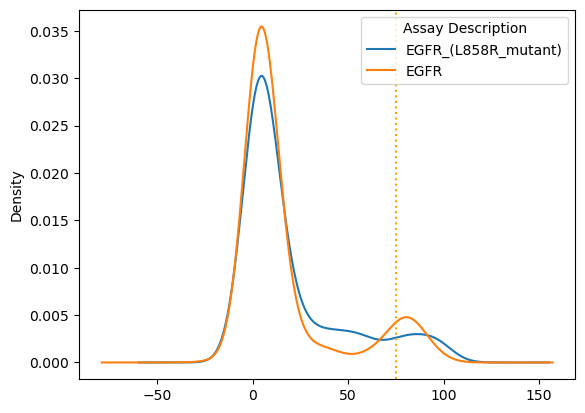

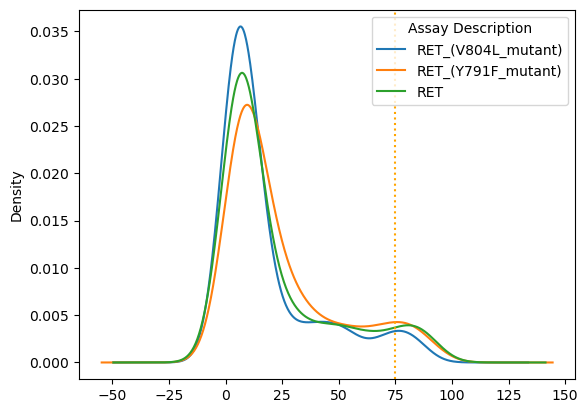

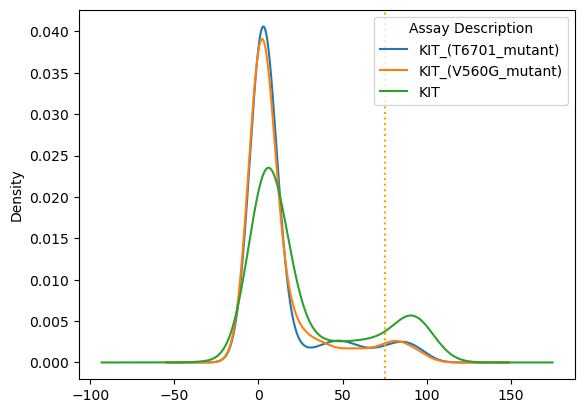

In [7]:
from matplotlib import pyplot as plt

for col in ["EGFR", "RET", "KIT"]:
    fig = data[[c for c in data_cols if col in c]].plot.kde()
    plt.axvline(x=75, linestyle="dotted", color="orange")

In [8]:
class_thresholds = {
    "EGFR_(L858R_mutant)": {"thresholds": [75]},
    "EGFR": {"thresholds": [75]},
    "KIT_(T6701_mutant)": {"thresholds": [75]},
    "KIT_(V560G_mutant)": {"thresholds": [75]},
    "KIT": {"thresholds": [75]},
    "RET_(V804L_mutant)": {"thresholds": [70]},
    "RET_(Y791F_mutant)": {"thresholds": [70]},
    "RET": {"thresholds": [70]},
}

In [9]:
class_thresholds

{'EGFR_(L858R_mutant)': {'thresholds': [75]},
 'EGFR': {'thresholds': [75]},
 'KIT_(T6701_mutant)': {'thresholds': [75]},
 'KIT_(V560G_mutant)': {'thresholds': [75]},
 'KIT': {'thresholds': [75]},
 'RET_(V804L_mutant)': {'thresholds': [70]},
 'RET_(Y791F_mutant)': {'thresholds': [70]},
 'RET': {'thresholds': [70]}}

### Run preliminary curation for data inspection
> See detailed documention of the data curation in [Polaris library](https://github.com/polaris-hub/polaris/blob/92888919194db9ad70b77fa55e10a7954c372eb9/polaris/curation/_curator.py#L13C13-L13C13)

In [10]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    class_thresholds=class_thresholds,
    keep_all_rows=True,
)
df_full = curator_with_stereo()

2023-11-07 16:45:45.527 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR_(L858R_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:45.529 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:45.530 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 12 outliers for data column KIT_(T6701_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:45.532 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 13 outliers for data column KIT_(V560G_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:45.534 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column RET_(V804L_mutant) usi

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

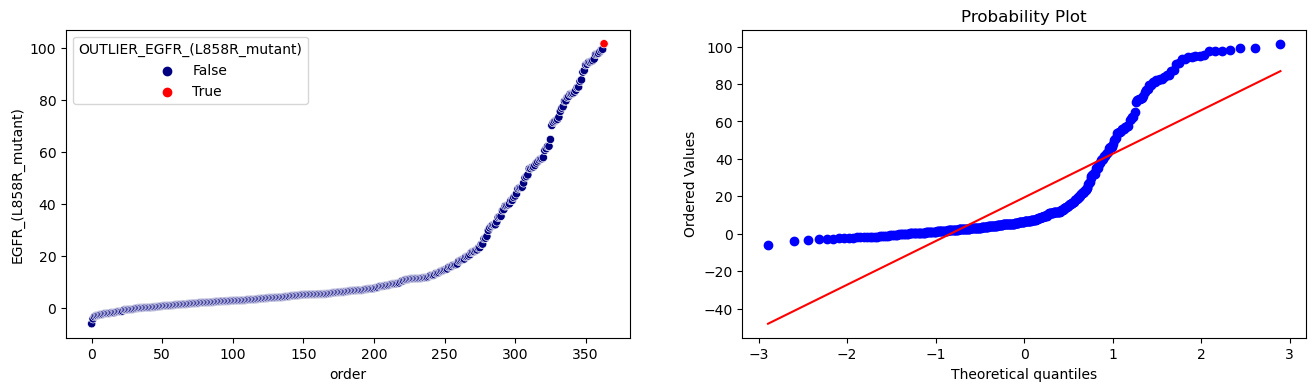

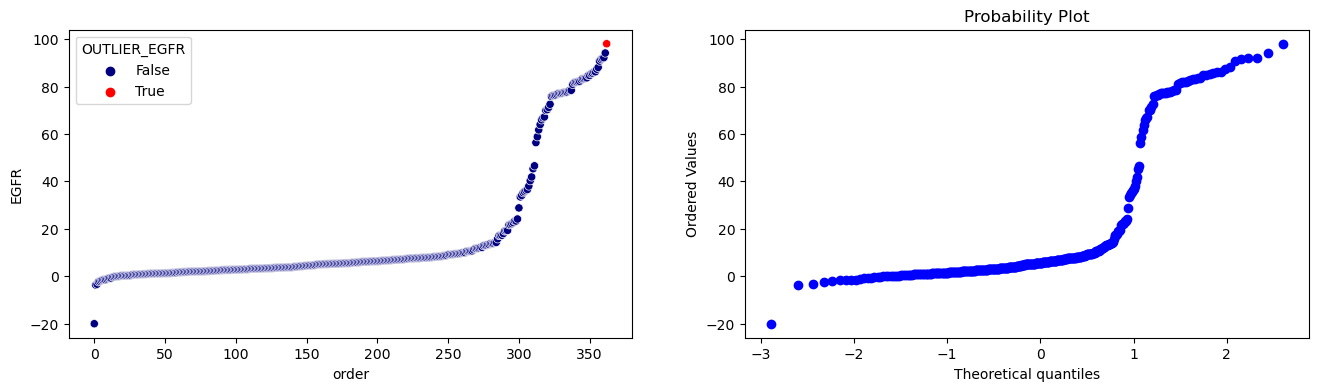

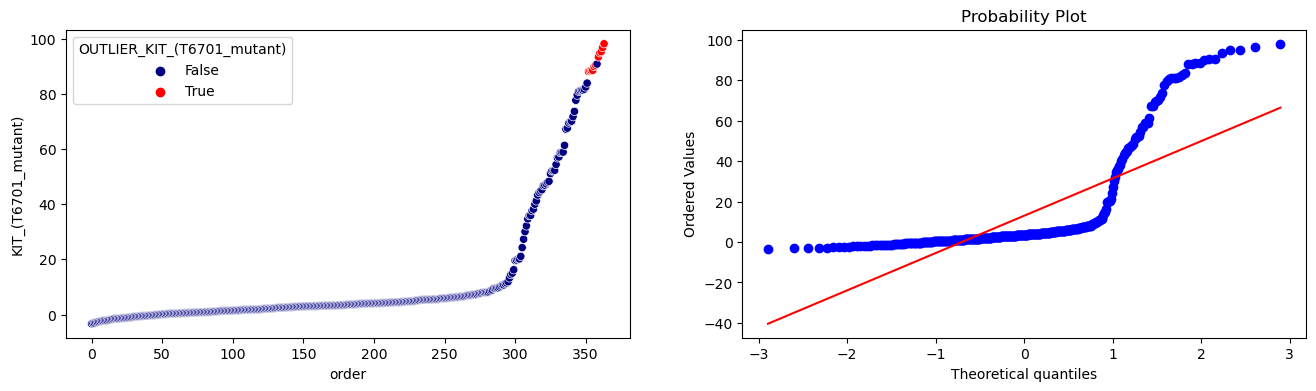

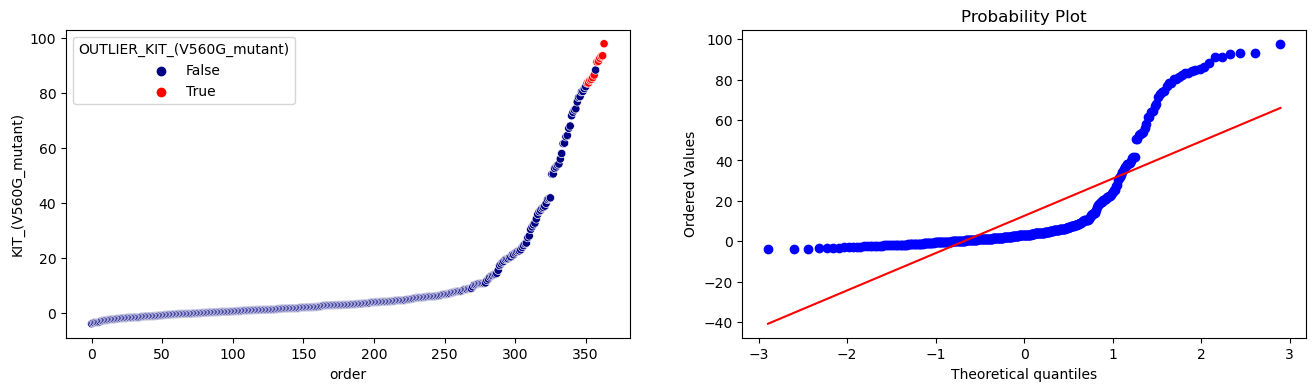

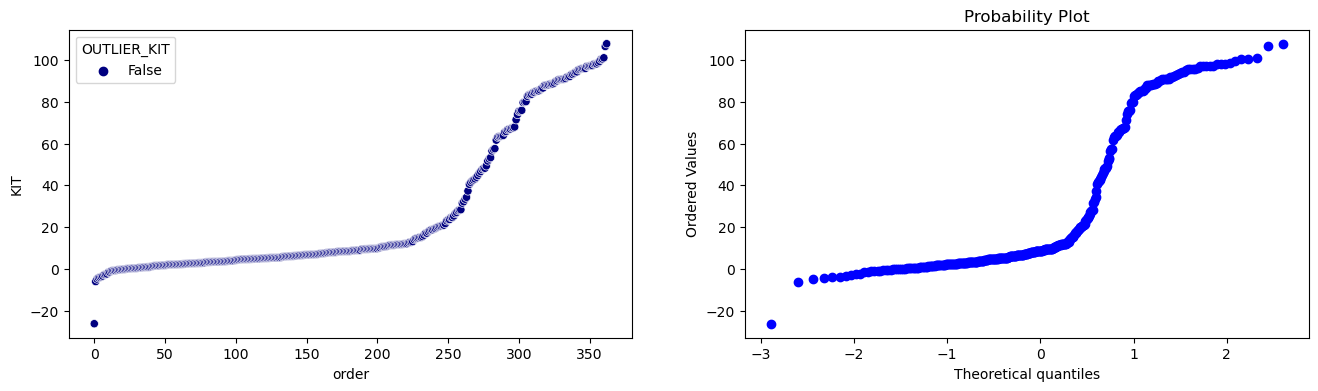

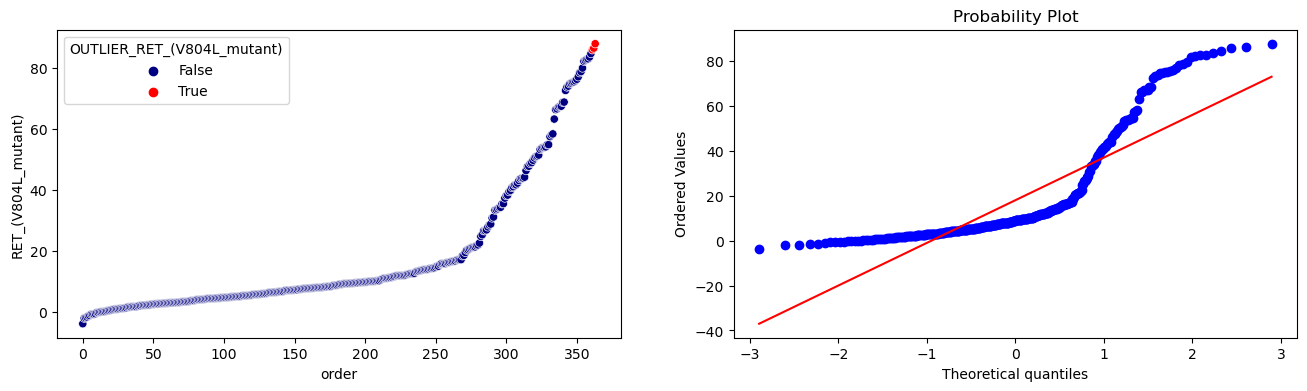

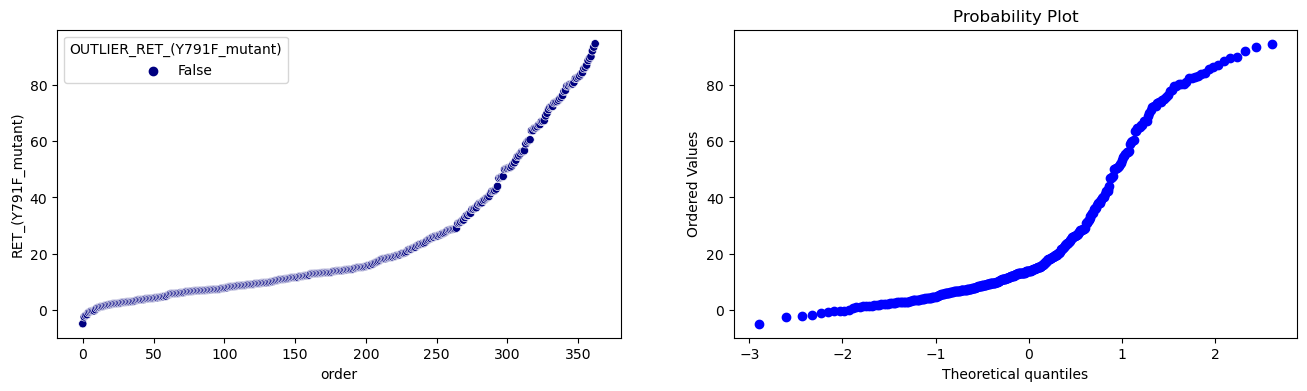

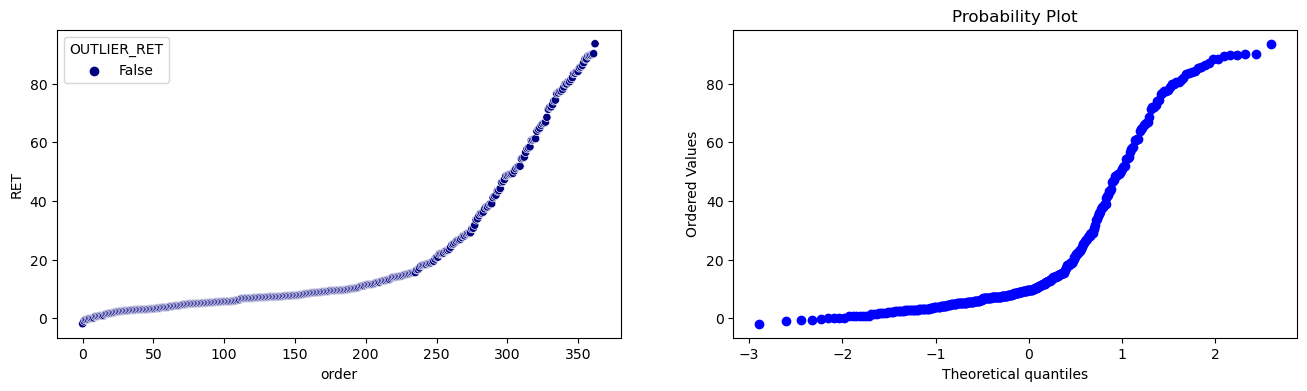

In [11]:
from polaris.curation.viz_utils import visulize_distribution

visulize_distribution(dataset=df_full, data_cols=data_cols)

### Check the activity shift between the stereo isomers

In [12]:
df_full[[col for col in df_full.columns if "stereo_cliff" in col]].sum()

Assay Description
CLASS_EGFR_(L858R_mutant)_stereo_cliff    0
CLASS_EGFR_stereo_cliff                   0
CLASS_KIT_(T6701_mutant)_stereo_cliff     0
CLASS_KIT_(V560G_mutant)_stereo_cliff     0
CLASS_KIT_stereo_cliff                    0
CLASS_RET_(V804L_mutant)_stereo_cliff     0
CLASS_RET_(Y791F_mutant)_stereo_cliff     4
CLASS_RET_stereo_cliff                    2
dtype: object

2023-11-07 16:45:48.075 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:56 - Verify the stereo ismomers for readout `EGFR_(L858R_mutant)`
2023-11-07 16:45:48.076 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:72 - No activity cliffs found in stereosimoers.
2023-11-07 16:45:48.076 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:56 - Verify the stereo ismomers for readout `EGFR`
2023-11-07 16:45:48.077 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:72 - No activity cliffs found in stereosimoers.
2023-11-07 16:45:48.077 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:56 - Verify the stereo ismomers for readout `KIT_(T6701_mutant)`
2023-11-07 16:45:48.077 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:72 - No activity cliffs found in stereosimoers.
2023-11-07 16:45:48.078 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:56 - Verify the stereo ismomers for readout `KIT_(V560G_mutant)`
2023-11-07 16:

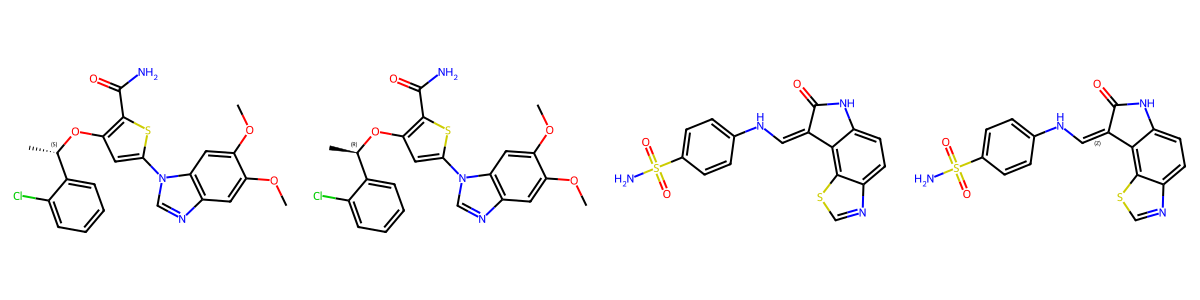

Assay Description,smiles,num_undefined_stereo_center,num_defined_stereo_center,RET_(Y791F_mutant),CLASS_RET_(Y791F_mutant)_stereo_cliff
216,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,0.0,1.0,72.03,True
71,COc1cc2ncn(-c3cc(O[C@H](C)c4ccccc4Cl)c(C(N)=O)...,0.0,1.0,63.76,True
211,NS(=O)(=O)c1ccc(NC=C2C(=O)Nc3ccc4ncsc4c32)cc1,NaN,NaN,72.37,True
157,NS(=O)(=O)c1ccc(N/C=C2\C(=O)Nc3ccc4ncsc4c32)cc1,NaN,NaN,68.99,True


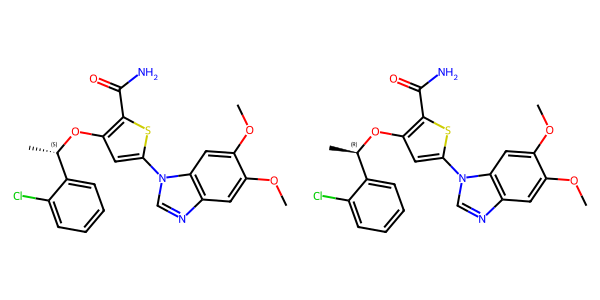

Assay Description,smiles,num_undefined_stereo_center,num_defined_stereo_center,RET,CLASS_RET_stereo_cliff
216,COc1cc2ncn(-c3cc(O[C@@H](C)c4ccccc4Cl)c(C(N)=O...,0.0,1.0,72.10,True
71,COc1cc2ncn(-c3cc(O[C@H](C)c4ccccc4Cl)c(C(N)=O)...,0.0,1.0,51.82,True


In [13]:
from polaris.curation.viz_utils import verify_stereoisomers

figs = verify_stereoisomers(dataset=df_full, data_cols=data_cols)
for col, (fig, df) in figs.items():
    display(fig)
    display(df)

With the predefined threshold value `>70`, a few of molecules has been detected having activity shift between the isomer for `RET_(Y791F_mutant)`, and `RET`. 
For the stereoisomers #216 and #71, the activity value on target `RET_(Y791F_mutant)` are very close, while there is a significant difference for target `RET`. The stereocenters of the pair of stereoisomers are well annotated.


For the second pair (#211 and #157) - the double bond isomers, the stereo information is not specified for the first molecule(#211). Given the activity values are similar. Therefore, we consider keepingß the molecule #211 for the target `RET_(Y791F_mutant)`.

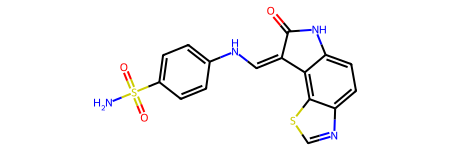

In [14]:
dm.to_mol(df_full.iloc[211].smiles)

In [15]:
data.loc[
    data.Smiles == "NS(=O)(=O)c1ccc(NC=C2C(=O)Nc3ccc4ncsc4c32)cc1", "RET_(Y791F_mutant)"
] = None

In [16]:
data.loc[
    data.Smiles == "NS(=O)(=O)c1ccc(NC=C2C(=O)Nc3ccc4ncsc4c32)cc1", "RET_(Y791F_mutant)"
]

309   NaN
Name: RET_(Y791F_mutant), dtype: float64

### Check the molecules with undefined stereocenters

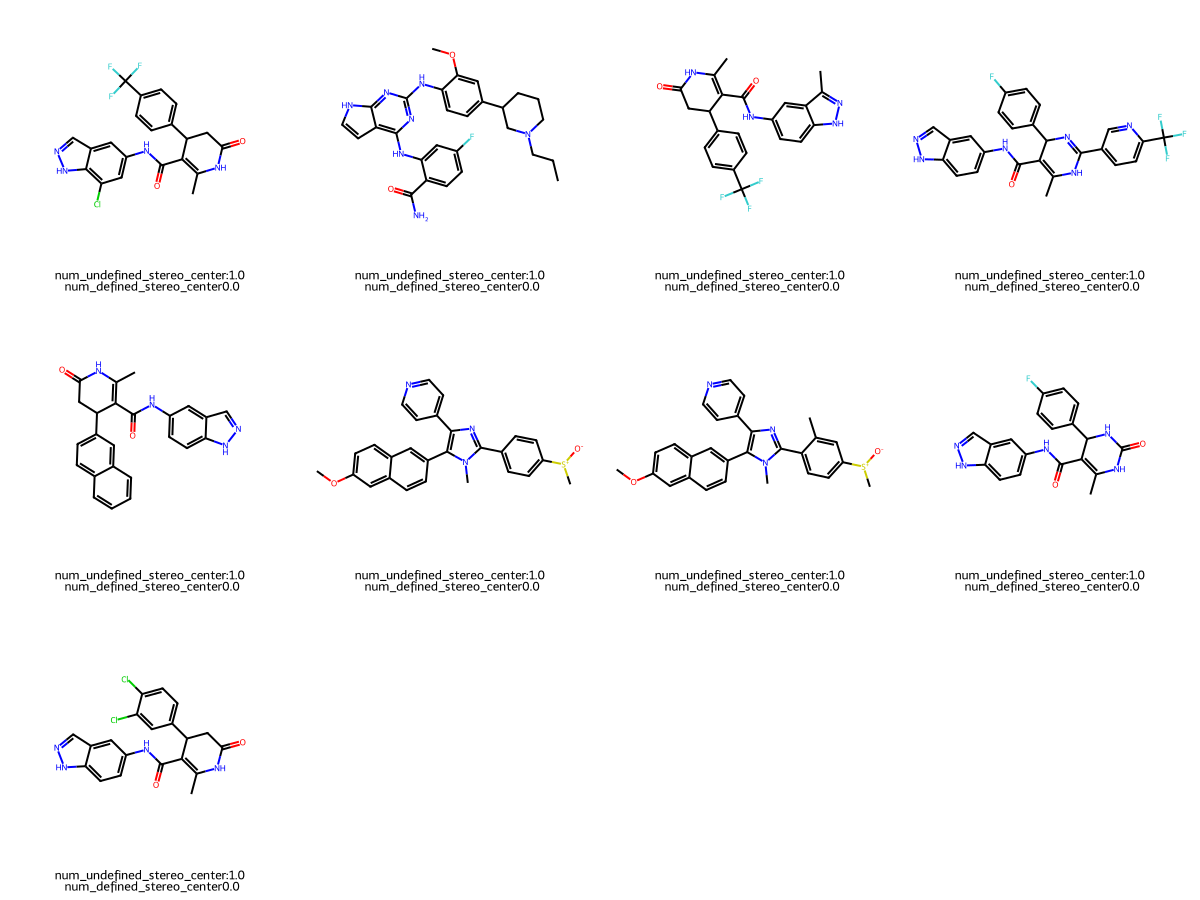

In [17]:
from polaris.curation.viz_utils import check_undefined_stereocenters

df_full["mol"] = df_full[mol_col].apply(dm.to_mol)
fig, unspecified_df = check_undefined_stereocenters(dataset=df_full)
fig

<Axes: >

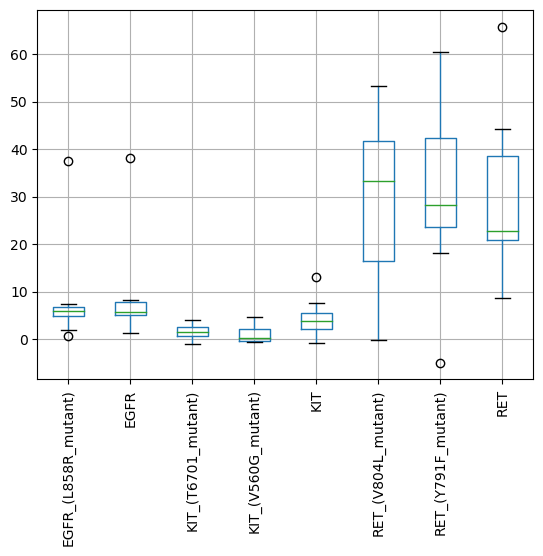

In [18]:
unspecified_df[data_cols].boxplot(rot=90)

The stereo center of the above molecules are unspecified or partially specified. The overall % inhibition is in the low to medium range. However, there are no activity shifts between the stereo isomers have been detected in this dataset. Therefore, we keep the above molecules in the dataset.

### Rerun the curation steps

In [19]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules which has undefined stereocenter and also show activity shift to the sterepisomers
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds,
    # remove all the molecules rows including the duplicates
    keep_all_rows=False,
)
df_curated = curator_with_stereo()

2023-11-07 16:45:50.053 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR_(L858R_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:50.055 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:50.056 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 12 outliers for data column KIT_(T6701_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:50.057 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 13 outliers for data column KIT_(V560G_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-11-07 16:45:50.059 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column RET_(V804L_mutant) usi

In [20]:
fout = f"{OUTDIR}/pkis1_subset_curated_v1.parquet"
df_curated.to_parquet(fout, index=False)

In [21]:
fout

'gs://polaris-public/data/Kinases/pkis1_subset_curated_v1.parquet'